In [1]:
import numpy as np
import os
import torch
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split

from e3nn import o3

from mace.modules import MACE, RealAgnosticResidualInteractionBlock

from graph2mat import metrics

from graph2mat import (
    BasisConfiguration,
    PointBasis,
    BasisTableWithEdges,
    MatrixDataProcessor,
)
from graph2mat.bindings.torch import TorchBasisMatrixDataset, TorchBasisMatrixData

from graph2mat.bindings.e3nn import E3nnGraph2Mat

# from graph2mat.tools.viz import plot_basis_matrix

from graph2mat.models import MatrixMACE

from graph2mat.bindings.e3nn import E3nnEdgeMessageBlock

from tools import get_atom_list, get_atom_position_list

import pickle

/Users/royalty/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-11-19 15:30:51.354554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [87]:
# load the original data

with open('data_631g.pkl', 'rb') as f:
    data = pickle.load(f)
    
# The basis 6-31g
hydrogen = PointBasis("H", R=2, basis="2x0e", basis_convention="spherical")
carbon = PointBasis("C", R=5, basis="3x0e + 2x1o", basis_convention="spherical")
basis_list = [hydrogen, carbon]

# prepare basis table and preprocessor
table = BasisTableWithEdges([hydrogen, carbon])

processor = MatrixDataProcessor(
    basis_table=table, symmetric_matrix=True, sub_point_matrix=False
)

# form the dataset

def prepare_config(atom_data, density_matrixes):
# def prepare_config(atom_data):
    configs = []
    for i in range(len(atom_data)):
        config = BasisConfiguration(
            point_types = ["C", "H", "H", "H", "H"],
            positions = get_atom_position_list(atom_data[i]),
            basis = basis_list,
            cell=np.eye(3) * 100,
            pbc=(False, False, False),
            matrix = np.array(density_matrixes[i])
        )
        configs.append(config)
    return configs

configs = prepare_config(data['feature'], data['target'])

# split the data and create the loaders

train_configs, val_configs = train_test_split(configs, test_size=0.25, random_state=56)

train_dataset = TorchBasisMatrixDataset(train_configs, data_processor=processor)
val_dataset = TorchBasisMatrixDataset(val_configs, data_processor=processor)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True, pin_memory=True)

# define the model

num_interactions = 3
hidden_irreps = o3.Irreps("1x0e + 1x1o")

mace_model = MACE(
    r_max=10,
    num_bessel=10,
    num_polynomial_cutoff=10,
    max_ell=2,  # 1,
    interaction_cls=RealAgnosticResidualInteractionBlock,
    interaction_cls_first=RealAgnosticResidualInteractionBlock,
    num_interactions=num_interactions,
    num_elements=2,
    hidden_irreps=hidden_irreps,
    MLP_irreps=o3.Irreps("2x0e"),
    atomic_energies=torch.tensor([0, 0]),
    avg_num_neighbors=2,
    atomic_numbers=[0, 1],
    correlation=2,
    gate=None,
)

# model_100 = MatrixMACE(
#     mace_model,
#     unique_basis=table,
#     readout_per_interaction=True,
#     edge_hidden_irreps=o3.Irreps("10x0e + 10x1o + 10x2e"),
#     preprocessing_edges=E3nnEdgeMessageBlock,
#     preprocessing_edges_reuse_nodes=False,
# )

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/mace/modules/blocks.py:140: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.

/Users/royalty/miniconda3/lib/python3.11/site-packages/torch/jit/_check.py:177: UserWarning:

The

In [ ]:
# # load the model

model_1000 = MatrixMACE(
    mace_model,
    unique_basis=table,
    readout_per_interaction=True,
    edge_hidden_irreps=o3.Irreps("10x0e + 10x1o + 10x2e"),
    preprocessing_edges=E3nnEdgeMessageBlock,
    preprocessing_edges_reuse_nodes=False,
)

<All keys matched successfully>

In [ ]:
model_1000.load_state_dict(torch.load('./models_25/model_2000.pt', map_location=torch.device('cpu')))

In [94]:
from graph2mat.tools.viz import plot_basis_matrix

# predict the density matrixes of the first sample of the validation set
sample = next(iter(val_loader))
# model_100.eval()
# prediction = model_100(sample)
model_1000.eval()
prediction = model_1000(sample)

def plot_matrices(data, predictions=None, title="", show=True):
    """Helper function to plot (possibly batched) matrices"""

    matrices = processor.matrix_from_data(data, predictions=predictions)

    if not isinstance(matrices, (tuple, list)):
        matrices = (matrices,)

    for i, (config, matrix) in enumerate(zip(configs, matrices)):
        if show is True or show == i:
            plot_basis_matrix(
                matrix,
                config,
                point_lines={"color": "#123456"},
                basis_lines={"color": "#888888"},
                colorscale="RdBu",
                text=".2f",
                basis_labels=True,
            ).update_layout(title=f"{title} [{i}]", width=700, height=700).show()

          
plot_matrices(sample, title=f"Target matrix", show=0)
plot_matrices(
    sample,
    predictions={
        "node_labels": prediction['node_labels'],
        "edge_labels": prediction['edge_labels'],
    },
    title=f"Prediction after {200} training steps",
    show=0,
)

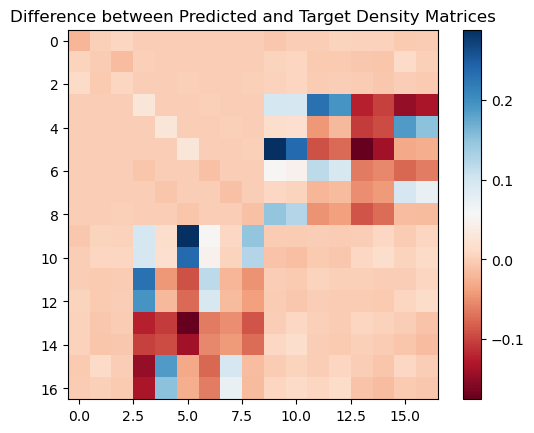

In [99]:
# find the difference between the predicted and the target density matrixes

special_config = BasisConfiguration(
            point_types = ["C", "H", "H", "H", "H"],
            positions = get_atom_position_list(data['feature'][0]),
            basis = basis_list,
            cell=np.eye(3) * 100,
            pbc=(False, False, False),
            matrix = np.array(data['target'][0])
        )

target_density_matrix = np.array(data['target'][0])

special_dataset = TorchBasisMatrixDataset([special_config], data_processor=processor)

special_loader = DataLoader(special_dataset, batch_size=1)

special_sample = next(iter(special_loader))

predicted_density_matrix = processor.matrix_from_data(special_sample, predictions=prediction)

predicted_density_matrix = predicted_density_matrix[0].toarray()

special_diff = target_density_matrix - predicted_density_matrix

import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
plt.imshow(special_diff, cmap='RdBu')
plt.colorbar()
plt.title('Difference between Predicted and Target Density Matrices')
plt.show()

In [97]:
from pyscf import gto, scf
import pickle
from tools import get_atom_coords, format_for_pyscf

# Load and parse the .xyz file
filename = "CH4.xyz"  # Replace with your .xyz file path
molecular_data = get_atom_coords(filename)

# take one frame every 25 frames

un_correlated_structures = []
for i in range(0, len(molecular_data), 25):
    mol = gto.Mole()
    mol.atom = format_for_pyscf(molecular_data[i])
    mol.basis = '6-31g'
    mol.build()
    un_correlated_structures.append(mol)
    
special_mol = un_correlated_structures[0]

mf = scf.RHF(special_mol)
mf.kernel()

dm = mf.make_rdm1()
# dm = target_density_matrix
hcore = mf.get_hcore() 
fock = mf.get_fock(dm=dm)


target_elec_energy = np.einsum('ij,ji->', dm, hcore) + 0.5 * np.einsum('ij,ji->', dm, fock)

predicted_elec_energy = np.einsum('ij,ji->', predicted_density_matrix, hcore) + 0.5 * np.einsum('ij,ji->', predicted_density_matrix, fock)

print(f'Target electronic energy: {target_elec_energy}')
print(f'Predicted electronic energy: {predicted_elec_energy}')

converged SCF energy = -40.1804247851503
Target electronic energy: -93.4732259297991
Predicted electronic energy: -82.36551568964317
